## US Airline Twitter Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import contractions
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import wordnet
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud,STOPWORDS
import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import balanced_accuracy_score,accuracy_score,classification_report,confusion_matrix
import random

In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
#Reading the data from a csv file

df_=pd.read_csv('Tweets.csv')

## Exploratory Data Analysis

In [4]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

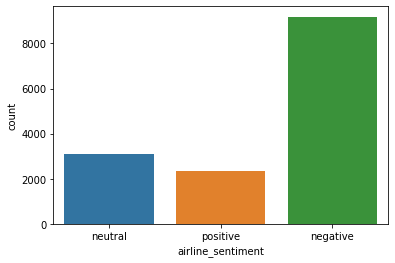

In [6]:
#Plotting the distribution of classes/sentiment

sns.countplot(x=df_.airline_sentiment);

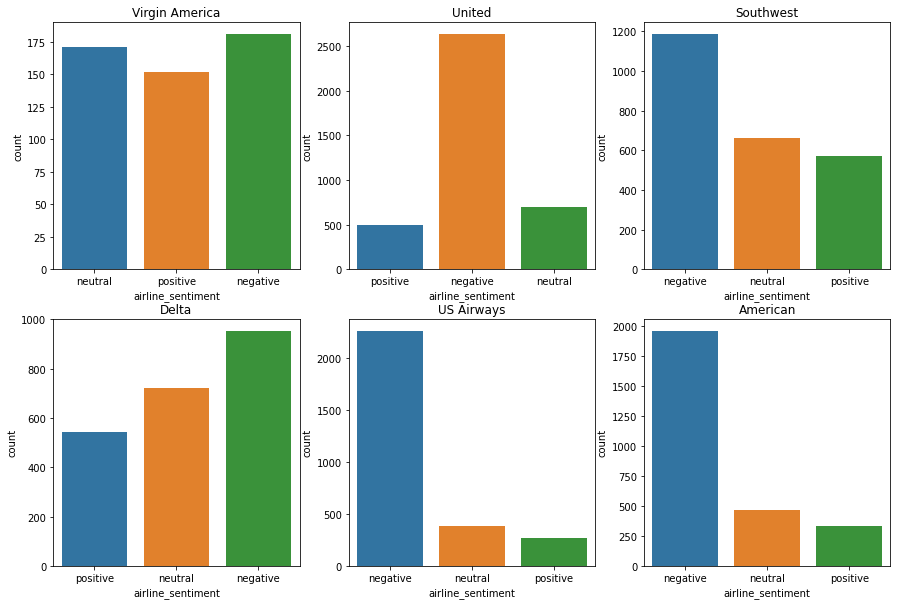

In [7]:
#Plotting the distribution of classes/sentiment with respect to each airline

plt.figure(figsize=(15,10))
for i,al in enumerate(df_.airline.unique(),1):
    df_airline=df_[df_['airline']==al]
    plt.subplot(230+i)
    sns.countplot(x=df_airline['airline_sentiment']).set(title=al)

In [8]:
#creating a separate dataframe so that we can predict the sentiment just by the content of the tweet

df=df_[['airline_sentiment','text']]

In [9]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [10]:
#checking missing values

df.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


## Data Preprocessing

In [15]:
#creating a seperate class for data cleaning

class CleanData:
    def __init__(self,stem=False,expand=False):
        self.lemmatizer=WordNetLemmatizer()
        self.stem=stem
        self.expand=expand
        
    def expand_words(self,tweet):
        tweet_exp=[]
        for word in tweet.split():
            tweet_exp.append(contractions.fix(word))
        return ' '.join(tweet_exp)

    def simple_pos(self,word):
        if word.startswith('J'):
            return 'a'
        elif word.startswith('R'):
            return 'r'
        elif word.startswith('V'):
            return 'v'
        else:
            return 'n'

    def lemmatize_words(self,words):
        pos=pos_tag(words.split())
        words_lemmatized=[]
        for i,word in enumerate(words.split()):
            words_lemmatized.append(self.lemmatizer.lemmatize(word=word,pos=self.simple_pos(pos[i][1])))

        return ' '.join(words_lemmatized)

    def fit(self,tweet):
        tweet=tweet.lower().strip()
        if self.expand and "'" in tweet:
            tweet=self.expand_words(tweet)

        #remove @tags and punctuations
        
        tags=r'@\w+'
        punc=r'[^\w\s]'   
        tags_removed=re.sub(tags,'',tweet)
        tweet=re.sub(punc,' ',tags_removed)

        if self.stem:
            tweet=self.lemmatize_words(tweet)
        
        #Removal of short words
        
        cleaned_tweets=[word for word in tweet.split() if len(word)>2]
        
            
        return ' '.join(cleaned_tweets)

In [22]:
data_cleaner=CleanData(stem=True,expand=True)
df['clean_data']=df['text'].apply(lambda x:data_cleaner.fit(x))
df['target']=df['airline_sentiment'].map({'positive':1,'neutral':0,'negative':-1})

In [23]:
df.head()

,airline_sentiment,text,clean_data,target
0,neutral,@VirginAmerica What @dhepburn said.,what say,0
1,positive,@VirginAmerica plus you've added commercials t...,plus you have add commercial the experience tacky,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,not today must mean need take another trip,0
3,negative,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...,-1
4,negative,@VirginAmerica and it's a really big bad thing...,and really big bad thing about,-1


Wordcloud for Word Frequency from all 'Neutral' sentiment.



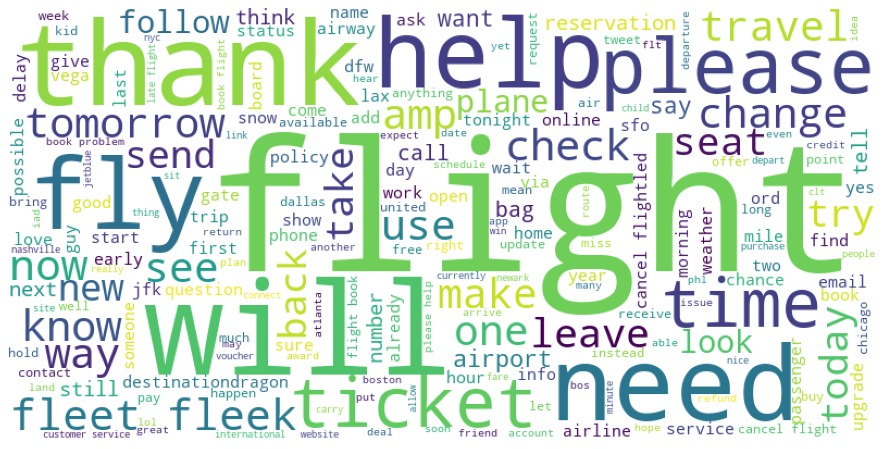





Wordcloud for Word Frequency from all 'Positive' sentiment.



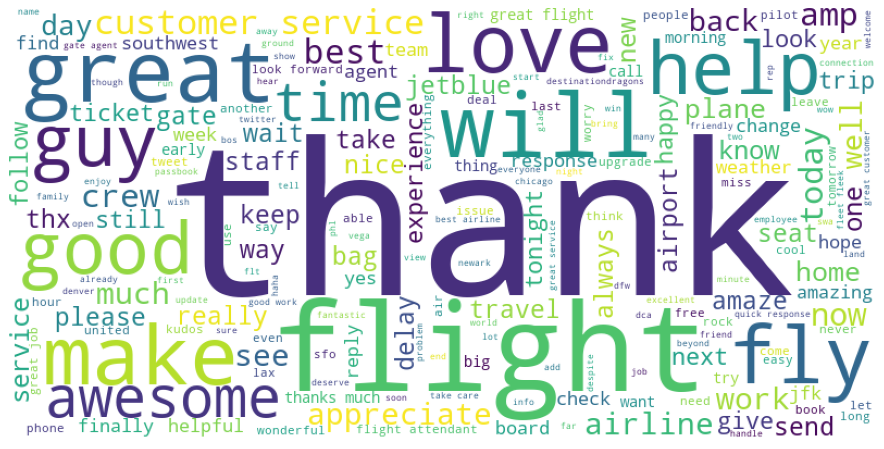





Wordcloud for Word Frequency from all 'Negative' sentiment.



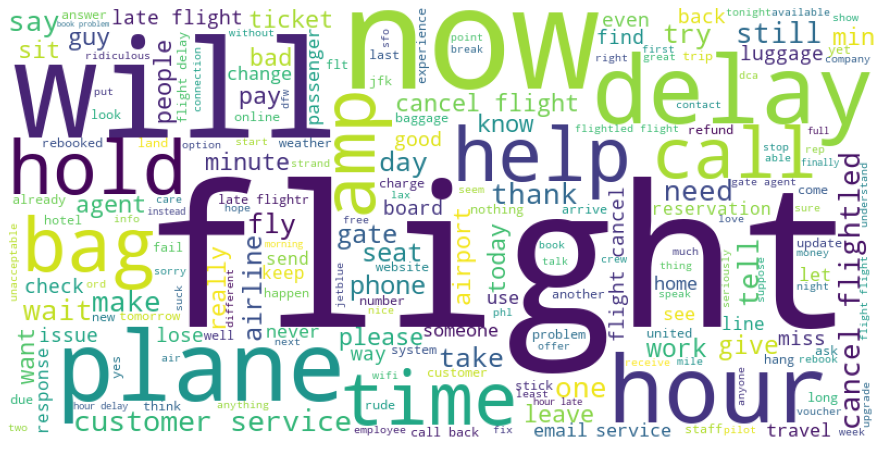

In [30]:
#Creating an image for each sentiment showing the most common words contributing to the sentiment

word_cloud=WordCloud(background_color='white',width=800,height=400,stopwords=STOPWORDS)
for sentiment in df['airline_sentiment'].unique():
    
    print("Wordcloud for Word Frequency from all '{}' sentiment.\n".format(sentiment.capitalize()))
    
    df_sentiment=df[df['airline_sentiment']==sentiment]
    words=' '.join(df_sentiment['clean_data'])
    image=word_cloud.generate(words)
    
    plt.figure(figsize=(16,8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print('\n\n\n')

In [32]:
random.seed(1234)

## Model Creation

In [33]:
X=df['clean_data'].values
Y=df['target'].values
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,stratify=Y)

In [34]:
# pipe=Pipeline([('transformer',TfidfVectorizer(stop_words={'english'})),
#                ('classifier',RandomForestClassifier())])
# grid=[
#     {'transformer__max_features':[5000,10000,15000],
#      'transformer__max_df':[1.0,0.9,0.8],
#      'transformer__min_df':[0.01,0.1,1.0],
#     'classifier':[LogisticRegression()],
#     'classifier__penalty':['l2'],
#     'classifier__solver':['newton-cg','saga','sag']},
    
#     {'transformer__max_features':[5000,10000,15000],
#      'transformer__max_df':[1.0,0.9,0.8],
#      'transformer__min_df':[0.01,0.1,1.0],
#      'classifier':[RandomForestClassifier()],
#     "classifier__n_estimators": [10, 100, 1000],
#     "classifier__max_depth":[5,8,15,25,30,None],
#     "classifier__min_samples_leaf":[1,2,5,10,15,100],
#     "classifier__max_leaf_nodes": [2, 5,10]},
    
#     {'transformer__max_features':[5000,10000,15000],
#      'transformer__max_df':[1.0,0.9,0.8],
#      'transformer__min_df':[0.01,0.1,1.0],
#     'classifier':[MultinomialNB()],
#     'classifier__alpha':[0.0,1.0],
#     'classifier__fit_prior':[True,False]}
    
# ]

In [35]:
# randomized_search=RandomizedSearchCV(pipe,grid,n_iter=300,cv=StratifiedKFold(),n_jobs=-1,
#                                      random_state=1,scoring='balanced_accuracy')
# best_model=randomized_search.fit(x_train,y_train)

In [36]:
# print(best_model.best_estimator_)
# print('Score:',best_model.score(x_test,y_test))

In [37]:
# best_model.best_score_

In [38]:
Classifiers = [
    LogisticRegression(max_iter=200),
    KNeighborsClassifier(),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    MultinomialNB()]

#### Data Transformation: TF-IDF vectorizer

In [39]:
tfidf=TfidfVectorizer(max_features=20000,stop_words={'english'})
x_train_tfidf=tfidf.fit_transform(x_train)
x_test_tfidf=tfidf.transform(x_test)


balanced_score_list_tfidf=[]
accuracy_score_list_tfidf=[]
classifier_names=[]
for clf in Classifiers:
    clf.fit(x_train_tfidf,y_train)
    y_pred=clf.predict(x_test_tfidf)
    
    clf_name=str(clf).split('(')[0]
    
    classifier_names.append(clf_name)
    accuracy_score_list_tfidf.append(accuracy_score(y_test,y_pred))
    balanced_score_list_tfidf.append(balanced_accuracy_score(y_test,y_pred))

In [40]:
df_tfidf=pd.DataFrame([accuracy_score_list_tfidf,balanced_score_list_tfidf],
                      index=['Accuracy Score','Balanced Accuracy Score'],
                      columns=classifier_names)
df_tfidf

,LogisticRegression,KNeighborsClassifier,SVC,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,MultinomialNB
Accuracy Score,0.794399,0.252049,0.787796,0.687842,0.762523,0.727914,0.677140
Balanced Accuracy Score,0.685341,0.395941,0.667142,0.603934,0.620472,0.591403,0.430783


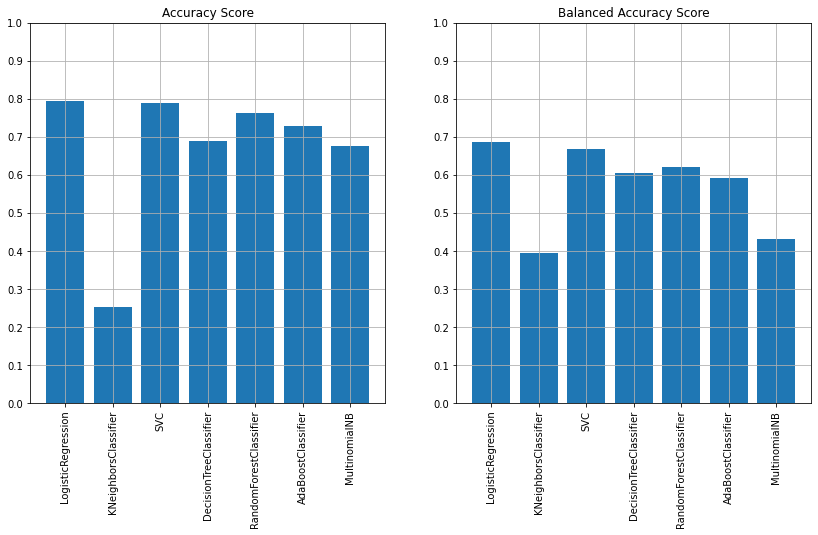

In [41]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.bar(classifier_names,accuracy_score_list_tfidf)
plt.xticks(rotation=90)
plt.yticks(np.arange(0,1.1,.1))
plt.title('Accuracy Score')
plt.grid()
plt.subplot(122)
plt.bar(classifier_names,balanced_score_list_tfidf)
plt.xticks(rotation=90)
plt.yticks(np.arange(0,1.1,.1))
plt.title('Balanced Accuracy Score')
plt.grid()
plt.show()

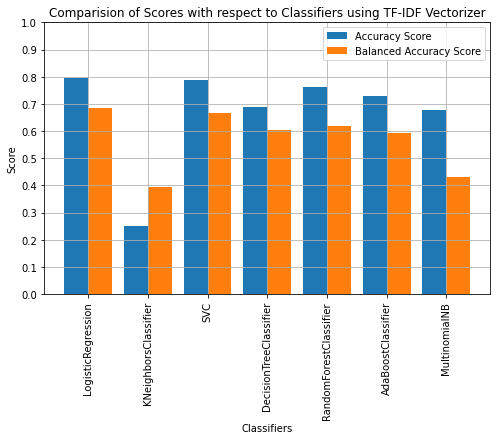

In [42]:
X_axis = np.arange(len(classifier_names))

plt.figure(figsize=(8,5))

plt.bar(X_axis - 0.2, accuracy_score_list_tfidf, 0.4, label = 'Accuracy Score')
plt.bar(X_axis + 0.2, balanced_score_list_tfidf, 0.4, label = 'Balanced Accuracy Score')
  
plt.xticks(X_axis, classifier_names,rotation=90)
plt.yticks(np.arange(0,1.1,.1))
plt.xlabel("Classifiers")
plt.ylabel("Score")
plt.title("Comparision of Scores with respect to Classifiers using TF-IDF Vectorizer")
plt.legend()
plt.grid()
plt.show()

#### Data Transformation: Count Vectorizer

In [43]:
count_vec=CountVectorizer(max_features=20000,stop_words={'english'})

x_train_cv=count_vec.fit_transform(x_train)
x_test_cv=count_vec.transform(x_test)

balanced_score_list_cv=[]
accuracy_score_list_cv=[]

for clf in Classifiers:
    clf.fit(x_train_cv,y_train)
    y_pred=clf.predict(x_test_cv)
    
    accuracy_score_list_cv.append(accuracy_score(y_test,y_pred))
    balanced_score_list_cv.append(balanced_accuracy_score(y_test,y_pred))

In [44]:
len(count_vec.vocabulary_)

9887

In [45]:
df_cv=pd.DataFrame([accuracy_score_list_cv,balanced_score_list_cv],
                      index=['Accuracy Score','Balanced Accuracy Score'],
                      columns=classifier_names)
df_cv

,LogisticRegression,KNeighborsClassifier,SVC,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,MultinomialNB
Accuracy Score,0.785747,0.543716,0.786202,0.704918,0.767304,0.731102,0.759335
Balanced Accuracy Score,0.712028,0.579155,0.683690,0.619829,0.637353,0.640483,0.603880


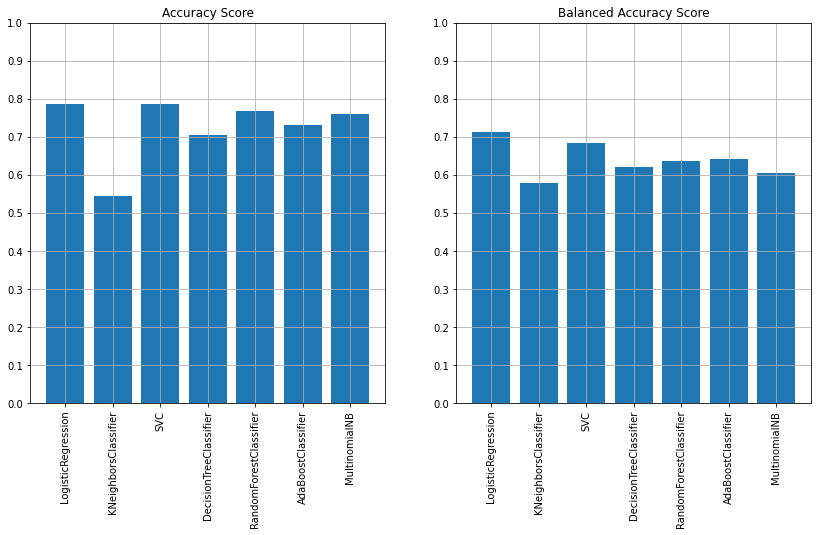

In [46]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.bar(classifier_names,accuracy_score_list_cv)
plt.xticks(rotation=90)
plt.yticks(np.arange(0,1.1,.1))
plt.title('Accuracy Score')
plt.grid()
plt.subplot(122)
plt.bar(classifier_names,balanced_score_list_cv)
plt.xticks(rotation=90)
plt.yticks(np.arange(0,1.1,.1))
plt.title('Balanced Accuracy Score')
plt.grid()
plt.show()

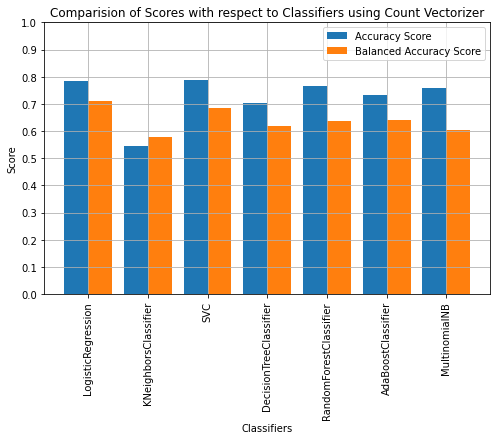

In [47]:
X_axis = np.arange(len(classifier_names))

plt.figure(figsize=(8,5))

plt.bar(X_axis - 0.2, accuracy_score_list_cv, 0.4, label = 'Accuracy Score')
plt.bar(X_axis + 0.2, balanced_score_list_cv, 0.4, label = 'Balanced Accuracy Score')
  
plt.xticks(X_axis, classifier_names,rotation=90)
plt.yticks(np.arange(0,1.1,.1))
plt.xlabel("Classifiers")
plt.ylabel("Score")
plt.title("Comparision of Scores with respect to Classifiers using Count Vectorizer")
plt.legend()
plt.grid()
plt.show()

#### From the above visualizations we can conclude that the best 3 performing classifiers were 
#### 1. Logistic Regression
#### 2. Random Forest Classifier 
#### 3. Support Vector Classifier

#### We can also conclude that "Count Vectorizer" produced marginally better results than "TF-IDF vectorizer"

Therefore we are going to tune the hyperparameters using GridSearchCV and Pipeline for those classifiers and see if we can improve the score and along with that choosing the best classifier

In [84]:
pipe=Pipeline([('transformer',CountVectorizer()),('classifier',LogisticRegression())])

grid=[
    {
    'transformer':[CountVectorizer()],
    'transformer__stop_words':[{'english'}],
    'transformer__max_features':[3000,6000,10000],
    'transformer__max_df':[1.0,0.9,0.8],
    'transformer__min_df':[1,0.1,0.2],
    'classifier':[LogisticRegression()],
    'classifier__max_iter':[75,100,150,200],
    'classifier__n_jobs':[-1],
    'classifier__penalty':['l2'],
    'classifier__solver':['newton-cg','sag','lbfgs']
    },
    
#     {
#     'transformer':[CountVectorizer()],
#     'transformer__stop_words':[{'english'}],
#     'transformer__max_features':[3000,6000,10000],
#     'transformer__max_df':[1.0,0.9,0.8],
#     'transformer__min_df':[1,0.1,0.2],
#     'classifier':[RandomForestClassifier()],
#     'classifier__n_jobs':[-1],
#     'classifier__n_estimators': [70, 85 ,100, 115 , 130],
#     'classifier__max_depth':[5,15,None],  #[5,15,None]
#     'classifier__min_samples_leaf':[1], # [1,10,50]
#     'classifier__max_leaf_nodes': [None]  # [2, 20,None]
#     },
    
    {
    'transformer':[CountVectorizer()],
    'transformer__stop_words':[{'english'}],
    'transformer__max_features':[6000], #[3000,6000,10000]
#     'transformer__max_df':[1.0,0.9,0.8],
#     'transformer__min_df':[1,0.1,0.2],
    'classifier':[SVC()],
    'classifier__probability':[True],
    'classifier__C':[2000,5000,10000],
    'classifier__gamma':['auto']
    }
    
]

In [85]:
grid_search=GridSearchCV(pipe,grid,cv=StratifiedKFold(),n_jobs=-1,error_score='raise',scoring='balanced_accuracy')
print('Grid Search Cross Validation in progress....')
best_model_grid=grid_search.fit(x_train,y_train)

# randomized_search=RandomizedSearchCV(pipe,grid,n_iter=300,cv=StratifiedKFold(),n_jobs=-1,error_score='raise',scoring='balanced_accuracy')
# print('Randomized Search Cross Validation in progress....')
# best_model_randomized=randomized_search.fit(x_train,y_train)

Grid Search Cross Validation in progress....


In [86]:
y_pred=best_model_grid.predict(x_test)

# y_pred=best_model_randomized.predict(x_test)

In [87]:
print('Best Transformer and Classifier parameters:\n',best_model_grid.best_estimator_)
print('Balanced Accuracy Score:',best_model_grid.score(x_test,y_test))
print('Accuracy Score:',accuracy_score(y_test,y_pred))
print('Classification Report:\n',classification_report(y_test,y_pred))
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))

# print('Best Transformer and Classifier parameters:\n',best_model_randomized.best_estimator_)
# print('Balanced Accuracy Score:',best_model_randomized.score(x_test,y_test))
# print('Accuracy Score:',accuracy_score(y_test,y_pred))
# print('Classification Report:\n',classification_report(y_test,y_pred))
# print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))

Best Transformer and Classifier parameters:
 Pipeline(steps=[('transformer',
                 CountVectorizer(max_features=10000, stop_words={'english'})),
                ('classifier', LogisticRegression(n_jobs=-1))])
Balanced Accuracy Score: 0.7177447337277957
Accuracy Score: 0.7903005464480874
Classification Report:
               precision    recall  f1-score   support

          -1       0.85      0.89      0.87      2753
           0       0.62      0.58      0.60       930
           1       0.74      0.68      0.71       709

    accuracy                           0.79      4392
   macro avg       0.74      0.72      0.73      4392
weighted avg       0.79      0.79      0.79      4392

Confusion Matrix:
 [[2445  229   79]
 [ 298  543   89]
 [ 127   99  483]]
